# Buy or Lease: Cars
---

### Project Goal
The goal of this project is to determine whether car leases are a good deal by comparing the total expense of a lease with the depreciation cost of a car. If the lease is more expensive we can conclude that it is more cost effective to buy the car new and resell it. However, if the lease is less expensive than we conclude you should lease instead of buy.

By using machine learning we predict the price of cars and use it to calculate the depreciation cost with which we compare to the cost of its lease.

The metric we use is *Root-Mean-Squared-Error* (RMSE) because it gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

So now we need data. Instead of collecting data on hundreds of different cars we only collect data on one of the best rated cars to lease, the Acura TLX. This helps us simplify the problem and if we conclude that you should buy instead of lease this car, we can conclude the same for lower rated cars.

In [754]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In this project we collect our data using BeautifulSoup’s library. We webscrape Acura TLX car listings off of Truecar.com. The notebook complete with code used for webscraping can be found [here](https://github.com/lukenew2/car-leases/blob/master/collect_data_webscraping.ipynb). 

Let’s load in the data we collected by webscraping and take a first initial look into it.

In [755]:
import pandas as pd

CARS_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets")

def load_car_data(cars_path=CARS_PATH):
    csv_path = os.path.join(cars_path, "cars.csv")
    return pd.read_csv(csv_path)

In [756]:
cars = load_car_data()

In [757]:
cars.head()

,Year,Make,Model,Mileage,Price,Drive,Engine,Trim,Exterior_color,Interior_color,Location,Accidents
0,2019,Acura,TLX,5215,38799.0,SH-AWD,3.5L V-6,3.5L SH-AWD with Advance Package,Black,Unknown,"Tustin, CA",0
1,2018,Acura,TLX,52438,21000.0,FWD,2.4L Inline-4,2.4L FWD with Technology Package,Red,Black,"Ellicott City, MD",0
2,2016,Acura,TLX,29581,17799.0,FWD,2.4L Inline-4,FWD,Blue,Unknown,"Tinley Park, IL",0
3,2017,Acura,TLX,25399,26679.0,SH-AWD,3.5L V-6,V6 SH-AWD with Advance Package,Black,Black,"Cockeysville, MD",0
4,2017,Acura,TLX,31930,19981.0,FWD,3.5L V-6,V6 FWD,White,Black,"Chantilly, VA",0


In [758]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2403 entries, 0 to 2402
Data columns (total 12 columns):
Year              2403 non-null int64
Make              2403 non-null object
Model             2403 non-null object
Mileage           2403 non-null int64
Price             2338 non-null float64
Drive             2402 non-null object
Engine            2402 non-null object
Trim              2402 non-null object
Exterior_color    2103 non-null object
Interior_color    2103 non-null object
Location          2403 non-null object
Accidents         2403 non-null int64
dtypes: float64(1), int64(3), object(8)
memory usage: 225.4+ KB


Let’s see how complete our dataset is. By looking at the percentage of null values for each column we can get a good idea of how many missing values we are dealing with.

In [759]:
cars.isnull().sum() / len(cars)

Year              0.000000
Make              0.000000
Model             0.000000
Mileage           0.000000
Price             0.027050
Drive             0.000416
Engine            0.000416
Trim              0.000416
Exterior_color    0.124844
Interior_color    0.124844
Location          0.000000
Accidents         0.000000
dtype: float64

We see there are missing values in 6 of our columns. Specifically in our target variable Price and attributes Drive, Engine, Trim, Exterior color, and Interior Color. Since Price is our target variable we will have to drop those instances. Since Drive, Engine, and Trim have a very low missing value percentage it should be okay to drop the instances pertaining to those instances as well. Since Exterior and Interior color are more than 10% null and probably won’t have much predictive power on price we will go ahead and drop those columns as well from the dataset.

In [760]:
cars.describe()

,Year,Mileage,Price,Accidents
count,2403.000000,2403.000000,2338.000000,2403.000000
mean,2017.676238,27201.252601,24856.005133,0.136912
std,1.529084,23253.457691,8153.910645,0.386036
min,2015.000000,0.000000,10931.000000,0.000000
25%,2017.000000,6986.500000,18588.000000,0.000000
50%,2017.000000,25096.000000,22000.000000,0.000000
75%,2019.000000,38767.000000,29995.000000,0.000000
max,2020.000000,150850.000000,55419.000000,3.000000


Our cars range from 2015 to 2020 and we will have to decide whether to keep them as integers or change them to categorical or ordinal.  There seems to be a few outliers with mileage and price that are more than 3 standard deviations away from the mean.  Standardizing our data will be very important.

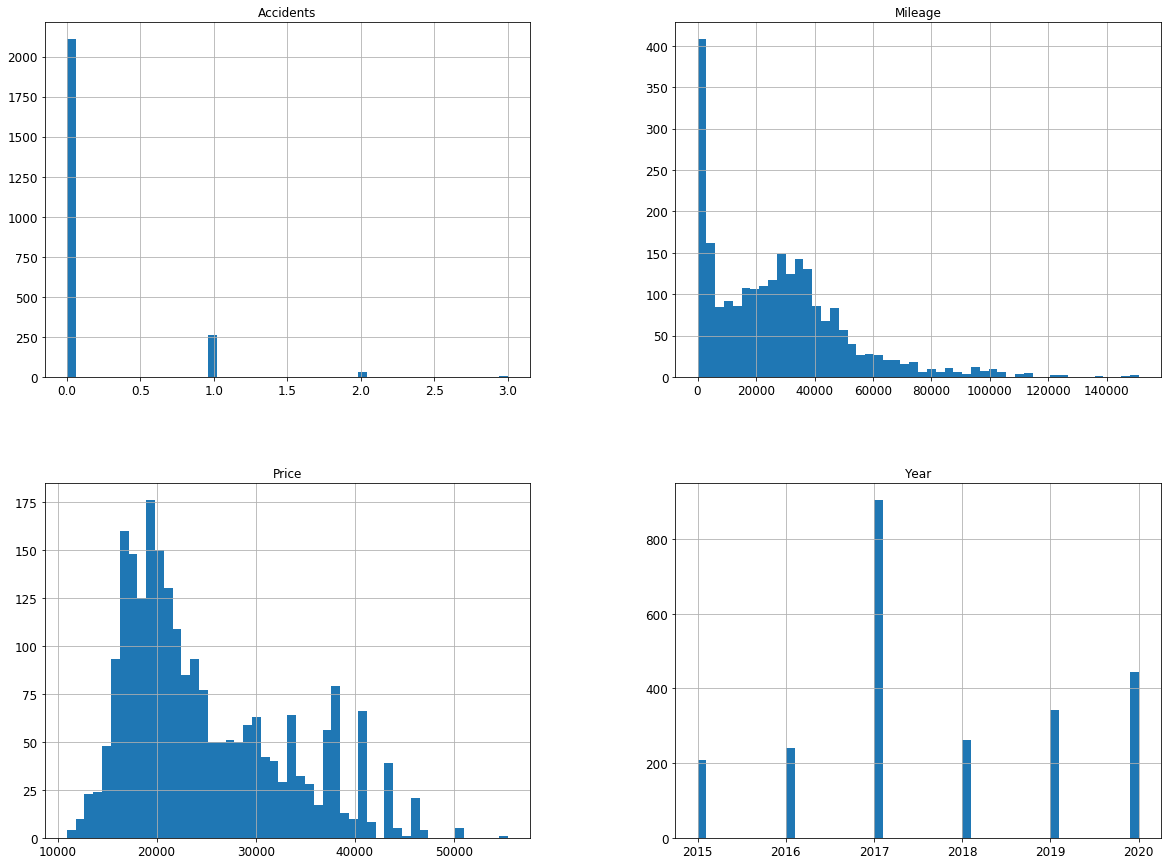

In [761]:
cars.hist(bins=50, figsize=(20,15))
plt.show()

## Summary

After taking a quick glance of the data there are some important things to take note of:
* Our target variable has 2% null values and will have to be removed.
* There are outliers and our numerical features are not normally distributed (we need to standardize numerical attributes).
* Exterior and Interior color columns will need to be dropped due to being 10% null and holding very little predictive power.

In [762]:
cars = cars.drop(columns=["Exterior_color", "Interior_color"])
cars = cars.dropna(axis=0)
cars.reset_index(inplace=True)

## Create a test set

We use a stratified split here to ensure our test set is as representative of the various ratios in the whole dataset. Since we believe certain features like the year of the car will be very important predictors of price we ensure that they are evenly distributed between the training and test set. By using a stratified split we avoid a sampling bias where the test is not representative of the whole dataset.

The following code uses the pd.cut() function to create a year category attribute with 6 categories (labeled from 0 to 5 and corresponding to each year in the dataset):

In [763]:
cars["Year_cat"] = pd.cut(cars["Year"],
                           bins=[2014.5, 2015.5, 2016.5, 2017.5, 2018.5, 2019.5, 2020.5],
                           labels=[0, 1, 2, 3, 4, 5])

In [764]:
cars["Year_cat"].value_counts()

2    874
5    441
4    338
3    255
1    228
0    201
Name: Year_cat, dtype: int64

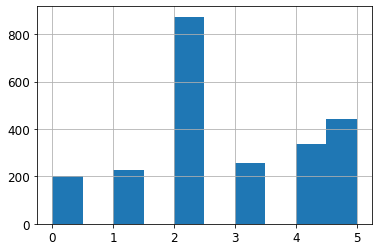

In [765]:
cars["Year_cat"].hist();

Now we are ready to do stratified sampling based on the year attribute. For this we can use Scikit-Learn’s StratifiedShuffleSplit() class:

In [766]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(cars, cars["Year_cat"]):
    train_set = cars.loc[train_index]
    test_set = cars.loc[test_index]

In [767]:
test_set["Year_cat"].value_counts() / len(test_set)

2    0.373932
5    0.188034
4    0.145299
3    0.108974
1    0.098291
0    0.085470
Name: Year_cat, dtype: float64

In [768]:
cars["Year_cat"].value_counts() / len(cars)

2    0.373984
5    0.188703
4    0.144630
3    0.109114
1    0.097561
0    0.086008
Name: Year_cat, dtype: float64

Now we remove the Year_cat attribute so the data is back to its original state:

In [769]:
for set_ in (test_set, train_set):
    set_.drop("Year_cat", axis=1, inplace=True)

# Explore the data

Let us now discover and visualize the data to get a feel of what it looks like and gain insights. We create a copy of the training set so we can play with it without harming the original training set.

Below is a table with the columns, data type, and a short description detailing what information they hold:

| Column Name | Type | Description | 
| --- | --- | --- |
| Year | Numerical | Year made |
| Price | Numerical | Price of car (target variable) |
| Mileage | Numerical | Amount of miles the car has been driven |
| Drive | Categorical | Type of drive (either "FWD" or "SH-AWD") |
| Engine | Categorical | Type of engine (either "2.4L Inline-4" or "3.5L V-6" |
| Trim | Categorical | Contains info on performance package |
| Location | Categorical | Where the car is listed for sale |
| Accidents | Numerical | Amount of accidents on car's title |

In [568]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 1527 to 1159
Data columns (total 11 columns):
index        1869 non-null int64
Year         1869 non-null int64
Make         1869 non-null object
Model        1869 non-null object
Mileage      1869 non-null int64
Price        1869 non-null float64
Drive        1869 non-null object
Engine       1869 non-null object
Trim         1869 non-null object
Location     1869 non-null object
Accidents    1869 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 175.2+ KB


In [569]:
cars = train_set.copy()

## Numerical Attributes

We will start by looking at the numerical data types and computing the standard correlation coefficient between every pair of attributes using the corr() method:

In [570]:
corr_matrix = cars.corr()

Now let’s look at how much each attribute correlates with the price:

In [571]:
corr_matrix["Price"].sort_values(ascending=False)

Price        1.000000
Year         0.848288
index        0.014088
Accidents   -0.234780
Mileage     -0.757645
Name: Price, dtype: float64

Another way to check for correlation between attributes is to use pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute.

Saving figure scatter_matrix_plot


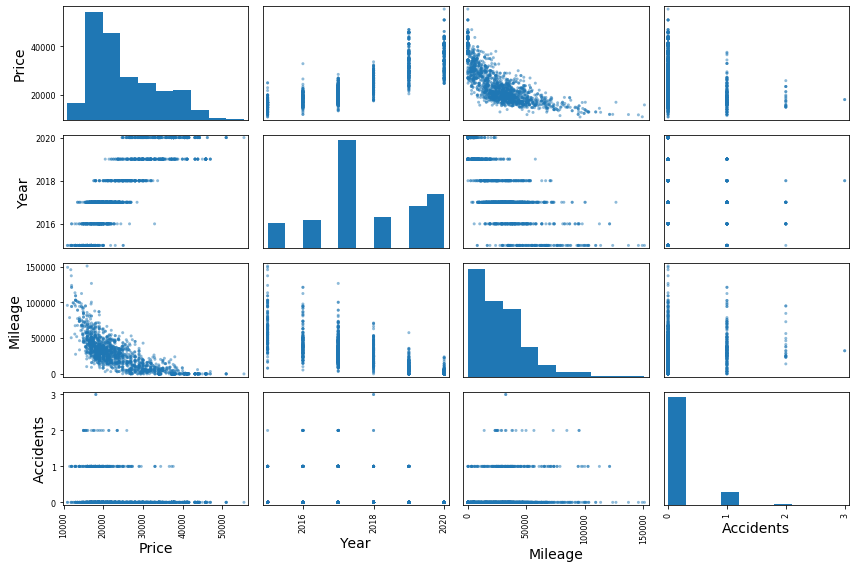

In [572]:
from pandas.plotting import scatter_matrix

attributes = ["Price", "Year", "Mileage", "Accidents"]
scatter_matrix(cars[attributes], figsize=(12,8))
save_fig("scatter_matrix_plot")

The figure above shows us a couple things. Indeed the attributes year and mileage are going to be very strong predictors of price and show some interaction that we might be able to capture by creating a new feature, miles per year. Also, there is not many instances with 3 accidents. It might be beneficial to group cars with 2 or 3 accidents into one value of 2 or more.

Saving figure mileage_vs_car_price_scatterplot


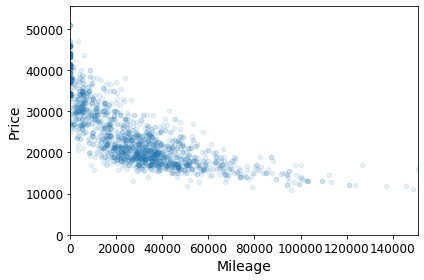

In [573]:
cars.plot(kind="scatter", x="Mileage", y="Price", alpha=0.1)
plt.axis([0, 150850, 0, 55420])
save_fig("mileage_vs_car_price_scatterplot")

To create the miles per year attribute we need to know how many years old the car is instead of the year. We achieve this through taking the absolute value of the current year subtracted from the year of the car. However, we won’t be able to divide by 0 for 2020 Acura TLXs so we will replace 0s with 1s (in this case the attribute miles_per_year will be the same as mileage).

In [574]:
cars["Years_old"] = abs(cars["Year"] - 2020)

In [575]:
cars["Miles_per_year"] = cars["Mileage"] / cars["Years_old"].replace(0, 1) 

Now let’s look at the correlation of our target price with the new attribute:

In [576]:
corr_matrix = cars.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price             1.000000
Year              0.848288
index             0.014088
Accidents        -0.234780
Miles_per_year   -0.591101
Mileage          -0.757645
Years_old        -0.848288
Name: Price, dtype: float64

Great! we see it is strongly correlated with the price as well!

In [577]:
cars[["Price", "Accidents"]].groupby("Accidents").median()

,Price
Accidents,
0,22998.0
1,18950.0
2,17498.0
3,18099.0


Since we do not have many instances with 3 accidents it might be better to group together cars with 2 or more accidents.  This way we'll preserve a stronger correlation.

In [578]:
cars["Accidents_cat"] = pd.cut(cars["Accidents"],
                                bins=[-0.1, 0.95, 1.95, np.inf],
                                labels=[0, 1, 2])

In [579]:
cars[["Price", "Accidents_cat"]].groupby("Accidents_cat").median()

,Price
Accidents_cat,
0,22998.0
1,18950.0
2,17798.0


## Categorical Attributes

Now we are going to look at the categorical features: Drive, Engine, and Trim. Location data will be hard to use because the cars are from all across the United States. We are using median on every groupby because our target variable price had a few outliers that can impact the mean.  

In [580]:
cars[["Price", "Drive"]].groupby("Drive").median()

,Price
Drive,
FWD,21165.0
SH-AWD,27900.0


In [581]:
cars[["Price", "Engine"]].groupby("Engine").median()

,Price
Engine,
2.4L Inline-4,19950.0
3.5L V-6,24291.5


One last interesting column I want to look at is Trim. This column contains a lot of information including the type of performance package on the car. It might be beneficial to extract the package and use it as an attribute instead. Let’s observe the correlation between different trims and median price.

In [582]:
cars[["Price", "Trim"]].groupby("Trim").median().sort_values("Price", ascending=False)

,Price
Trim,
3.5L SH-AWD PMC Edition,50945.0
3.5L SH-AWD with A-Spec Package Red Leather,45795.0
3.5L SH-AWD with Advance Package,35975.0
3.5L SH-AWD with A-Spec Package,35674.0
2.4L FWD with A-Spec Package Red Leather,34588.0
3.5L SH-AWD with Technology Package,33116.5
3.5L FWD with A-Spec Package Red Leather,32988.0
3.5L FWD with Advance Package,32649.5
2.4L FWD with A-Spec Package,32394.5


Now let’s extract the package and see if there is any obvious correlation between packages.

In [583]:
def extract_package(trims):
    
    packages = ["PMC Edition", "A-Spec", "Advance", "Technology"]

    pat = '|'.join(r"\b{}\b".format(x) for x in packages)
    packages = pd.Series(trims).str.extract("(" + pat + ")", expand=False)
    packages.fillna("Standard", inplace=True)
    
    return packages

In [584]:
cars["Package"] = extract_package(cars["Trim"].values)

In [585]:
cars[["Price", "Package"]].groupby("Package").median().sort_values("Price", ascending=False)

,Price
Package,
PMC Edition,35918.0
Advance,22996.5
Technology,22560.0
A-Spec,21931.5
Standard,21701.0


Extracting the package does not seem very helpful. The correlation is weak between different packages and does not follow any trends we expect.

In [586]:
cars.describe()

,index,Year,Mileage,Price,Accidents,Years_old,Miles_per_year
count,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000
mean,1184.403959,2017.695024,26527.240770,24927.822900,0.131621,2.304976,9361.152550
std,692.248579,1.531987,22894.634725,8195.536348,0.381323,1.531987,6768.613024
min,0.000000,2015.000000,0.000000,10931.000000,0.000000,0.000000,0.000000
25%,580.000000,2017.000000,6476.000000,18590.000000,0.000000,1.000000,4931.333333
50%,1171.000000,2017.000000,24360.000000,22038.000000,0.000000,3.000000,9016.500000
75%,1784.000000,2019.000000,38213.000000,29999.000000,0.000000,3.000000,12820.000000
max,2402.000000,2020.000000,150850.000000,55419.000000,3.000000,5.000000,57654.000000


## Summary

Now we have a pretty good idea of which features will be the most valuable and have explored relations between them. Some important findings were:
* Creating new column miles_per_year adds additional predictive power.
* Cars with more than 2 accidents are very sparse in our dataset and it would be better to group together with cars having 2 accidents. We preserve a stronger correlation this way.
* Year will be better to use as an ordinal feature. We will subtract the current year of the column to create a column called “years old”.
* Extracting the performance package from trim might or might not be useful. There isn’t a clear correlation with price so we can add this as an option in our data preparation phase.

# Prepare data for machine learning

It’s time to prepare the data for Machine Learning algorithms. Instead of doing this manually, we write functions for this purpose, for several good reasons:
* This will allow us to reproduce these transformations on any dataset (e.g., the next time you get a fresh dataset).
* We will gradually build a library of transformation functions that we can reuse in future projects.
* This will make it possible for us to easily try various transformations and see which combination of transformations work best.

We need a preparation pipeline for numerical attributes and categorical attributes. Let’s start with the numerical attributes!

In [785]:
X_train = train_set.drop("Price", axis=1)
y_train = train_set["Price"].copy()

we reorder columns so numerical attributes are before categorical (not necessary).

In [786]:
cols = ["Year", "Mileage", "Accidents", "Drive", "Engine", "Trim"]

X_train = X_train[cols]
X_train.head()

,Year,Mileage,Accidents,Drive,Engine,Trim
1527,2017,50008,0,FWD,2.4L Inline-4,I4 FWD
275,2019,29795,0,FWD,2.4L Inline-4,2.4L FWD with Technology Package
430,2020,0,0,SH-AWD,3.5L V-6,3.5L SH-AWD with A-Spec Package
1139,2019,14755,0,FWD,3.5L V-6,3.5L FWD with A-Spec Package
1583,2015,34637,0,FWD,3.5L V-6,V6 FWD with Technology Package


Since we are using Scikit-Learn we want our transformers to work seamlessly with Scikit-Learn functionalities (such as pipelines), but thankfully for us all we need to do is create a class and implement three methods: fit() (which returns self), transform(), and fit_transform(). We get the last one for free by simply adding TransformerMixin as a base class.

We also add BaseEstimator as a base class which gives us two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning.

## Numerical Pipeline

For example, here is a transformer class that adds the numerical attributes which were discussed earlier and its output when we pass it our training set.

In [609]:
from sklearn.base import BaseEstimator, TransformerMixin

class NumericalAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_miles_per_year = True):
        self.add_miles_per_year = add_miles_per_year
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        years_old = abs(X["Year"] - 2020)
        accidents_adjusted = X["Accidents"].replace(3, 2)
        if self.add_miles_per_year:
            miles_per_year = X["Mileage"] / years_old.replace(0, 1)
            return pd.concat([X, years_old.rename("Years_old"),
                              accidents_adjusted.rename("Accidents_adj"),
                              miles_per_year.rename("Miles_per_year")],
                              axis=1)
        else:
            return pd.concat([X, years_old.rename("Years_old"),
                              accidents_adjusted.rename("Accidents_adj")],
                              axis=1)
        
num_attr_adder = NumericalAttributesAdder(add_miles_per_year = True)
num_attr_adder.transform(X_train)

,Year,Mileage,Accidents,Drive,Engine,Trim,Years_old,Accidents_adj,Miles_per_year
1527,2017,50008,0,FWD,2.4L Inline-4,I4 FWD,3,0,16669.333333
275,2019,29795,0,FWD,2.4L Inline-4,2.4L FWD with Technology Package,1,0,29795.000000
430,2020,0,0,SH-AWD,3.5L V-6,3.5L SH-AWD with A-Spec Package,0,0,0.000000
1139,2019,14755,0,FWD,3.5L V-6,3.5L FWD with A-Spec Package,1,0,14755.000000
1583,2015,34637,0,FWD,3.5L V-6,V6 FWD with Technology Package,5,0,6927.400000
...,...,...,...,...,...,...,...,...,...
182,2016,57832,0,FWD,3.5L V-6,V6 FWD with Technology Package,4,0,14458.000000
1622,2017,36472,1,FWD,2.4L Inline-4,I4 FWD,3,1,12157.333333
2098,2016,32311,1,FWD,3.5L V-6,V6 FWD,4,1,8077.750000
1120,2018,11802,0,FWD,3.5L V-6,3.5L FWD with Technology Package,2,0,5901.000000


Now after we add new attributes we want to select which attributes we use in our machine learning algorithms. We use the same method as above to create a custom transformer that will select the attributes.

In [617]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_indices]

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with sequences of transformations. Here is the pipeline for the numerical attributes:

In [737]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = ["Year", "Mileage", "Accidents"]

cars_num = X_train[num_attribs]

num_pipeline = Pipeline([
        ('num_attribs_adder', NumericalAttributesAdder()),
        ('select_numeric', DataFrameSelector(["Mileage", "Years_old", "Accidents_adj", "Miles_per_year"])),
        ('std_scaler', StandardScaler())
    ])

cars_num_tr = num_pipeline.fit_transform(cars_num)

We used our two custom transformers from above and then Scikit-Learn’s StandardScaler() transformer to standardize all numerical attributes.

## Categorical Pipeline

Now the next step is to create a pipeline for our categorical attributes. Since these attributes are strings, we need to use OneHotEncoder to transform them into numerical values. But first we create a custom transformer that will extract the package of a car from the Trim attribute we discussed earlier. We initialize add_trim_features=True to give us the option whether to add the new package attribute.

In [613]:
class CategoricalAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_trim_features = True):
        self.add_trim_features = add_trim_features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.add_trim_features:
            package = extract_package(X["Trim"])
            return pd.concat([X, package.rename("Package")], axis=1)
        else:
            return X
        
cat_attr_adder = CategoricalAttributesAdder(add_trim_features = True)
cat_attr_adder.transform(X_train)

,Year,Mileage,Accidents,Drive,Engine,Trim,Package
1527,2017,50008,0,FWD,2.4L Inline-4,I4 FWD,Standard
275,2019,29795,0,FWD,2.4L Inline-4,2.4L FWD with Technology Package,Technology
430,2020,0,0,SH-AWD,3.5L V-6,3.5L SH-AWD with A-Spec Package,A-Spec
1139,2019,14755,0,FWD,3.5L V-6,3.5L FWD with A-Spec Package,A-Spec
1583,2015,34637,0,FWD,3.5L V-6,V6 FWD with Technology Package,Technology
...,...,...,...,...,...,...,...
182,2016,57832,0,FWD,3.5L V-6,V6 FWD with Technology Package,Technology
1622,2017,36472,1,FWD,2.4L Inline-4,I4 FWD,Standard
2098,2016,32311,1,FWD,3.5L V-6,V6 FWD,Standard
1120,2018,11802,0,FWD,3.5L V-6,3.5L FWD with Technology Package,Technology


Now the full pipeline for our categorical attributes is ready. We use CategoricalAttributesAdder, DataFrameSelector, and OneHotEncoder to completely transform our categorical attributes into a format suited for Machine Learning. The pipeline is shown below:

In [738]:
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ["Drive", "Engine", "Trim"]
cars_cat = X_train[cat_attribs]

cat_pipeline = Pipeline([
        ("cat_attribs_adder", CategoricalAttributesAdder()),
        ("select_categoric", DataFrameSelector(["Drive", "Engine", "Trim"])),
        ("one_hot", OneHotEncoder())
    ])

cars_cat_tr = cat_pipeline.fit_transform(cars_cat)

## Full Pipeline

So far, we have handled the categorical columns and numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column. Fortunately, Scikit-Learn introduced the ColumnTransformer for this purpose, and the good news is that it works great with pandas DataFrames. Let’s use it to apply all the transformations to the training set:

In [739]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs)
    ])

cars_prepared = full_pipeline.fit_transform(X_train)

In [740]:
cars_prepared.shape

(1869, 32)

In this pipeline, we specify that the numerical columns should be transformed using the num_pipeline that we defined earlier, and the categorical columns should be transformed using the cat_pipeline we defined earlier. Finally, we apply this ColumnTransformer to the training set: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

And that’s it! We have a preprocessing pipeline that takes the full training set and applies the appropriate transformations to each column.

# Modeling

At last! We framed the problem, got the data and explored it, sampled a training set and a test set, and we wrote transformation pipelines to clean up and prepare our data for Machine Learning algorithms automatically. We are now ready to select and train Machine Learning models.

Our first base model is a Linear Regression with which we will try to improve from. Using Scikit-Learn’s cross_val_score() allows us to randomly split the training set into 10 distinct folds, and then train and evaluates our model 10 times, picking a different fold for evaluation each time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

## Base model - Linear Regression

In [643]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg_scores = np.sqrt(-cross_val_score(lin_reg, cars_prepared, y_train, cv=10, scoring="neg_mean_squared_error"))

In [644]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(lin_reg_scores)

Scores: [2402.53150985 2563.72194172 2992.14666264 2523.37921743 2115.13853928
 2462.32000582 2171.3699367  2402.83363175 2564.96795384 2287.88676613]
Mean: 2448.629616517125
Standard deviation: 233.69132661285403


## Polynomical Regression

Polynomial regression might be able to better capture the fact that cars depreciate less and less each year they get older.  We will try to capture this relationship with a polynomial degree of 2.

In [648]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("lin_reg", LinearRegression())
    ])

poly_reg_scores = np.sqrt(-cross_val_score(poly_reg, cars_prepared, y_train, cv=10,
                                           scoring="neg_mean_squared_error"))

In [649]:
display_scores(poly_reg_scores)

Scores: [2042.79207444 3377.46658497 2736.91927982 2146.09447092 1827.28906299
 2503.52321105 1745.79756458 2111.21893759 2140.79878176 1950.68731506]
Mean: 2258.2587283169737
Standard deviation: 466.8267908064259


## Polynomial Regression with Ridge Regularization

Since the polynomial regression performed better than the base linear regression we can try a regularized version of it to see if we can improve performance even more.

In [679]:
from sklearn.linear_model import Ridge

ridge_poly_reg = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("lin_reg", Ridge(alpha=0.1, solver="sag"))
    ])

ridge_poly_reg_scores = np.sqrt(-cross_val_score(en_poly_reg, cars_prepared, y_train, cv=10,
                                              scoring="neg_mean_squared_error"))

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [680]:
display_scores(ridge_poly_reg_scores)

Scores: [1990.82244837 3306.48583544 2800.9621974  2289.81793015 1890.16896942
 2462.9164702  1795.59395914 2170.30275306 2066.21332387 2033.98008065]
Mean: 2280.7263967698104
Standard deviation: 441.26289925102543


## Random Forest Regressor

Since it seems we reached the best we can do with a simple linear model let's try a very different model––A Random Forest Regressor.  

In [663]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

forest_reg_scores = np.sqrt(-cross_val_score(forest_reg, cars_prepared, y_train, cv=10,
                                             scoring="neg_mean_squared_error"))

In [664]:
display_scores(forest_reg_scores)

Scores: [1393.02402836 1763.02415225 2196.74228505 1748.00154264 1567.88625726
 1699.62388666 1587.52998912 1632.53623941 1443.80229374 1326.9144935 ]
Mean: 1635.9085167991286
Standard deviation: 233.59607429848862


## Support Vector Machine Regressor

Let's try a SVM Regressor.  Since our dataset is small I suspect SVM might work fairly well.  We will use a polynomial kernel with a degree of 2 since we suspect our data to have a polynomial relationship with the target variable.

In [675]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")

svm_reg_scores = np.sqrt(-cross_val_score(svm_reg, cars_prepared, y_train, cv=10,
                                          scoring="neg_mean_squared_error"))

In [676]:
display_scores(svm_reg_scores)

Scores: [3337.59837592 3715.04354926 3244.33675717 3218.39572011 2261.11591161
 3340.71066296 3493.34243379 3264.47141529 3903.93099711 3317.26224324]
Mean: 3309.6208066471336
Standard deviation: 408.3036321268142


## Gradient Boosting Regressor

Since Random Forest Regressor worked significantly better than all the other models we will try a Gradient Boosting Regressor as well.

In [677]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor()

gb_reg_scores = np.sqrt(-cross_val_score(gb_reg, cars_prepared, y_train, cv=10,
                                         scoring="neg_mean_squared_error"))

In [678]:
display_scores(gb_reg_scores)

Scores: [1576.26597181 1862.18024158 2240.38399831 1738.09142372 1509.8881473
 1901.97734642 1681.26645723 1844.06641238 1678.40402158 1499.69591823]
Mean: 1753.2219938570713
Standard deviation: 211.04125417672495


Saving figure box_plot_scores


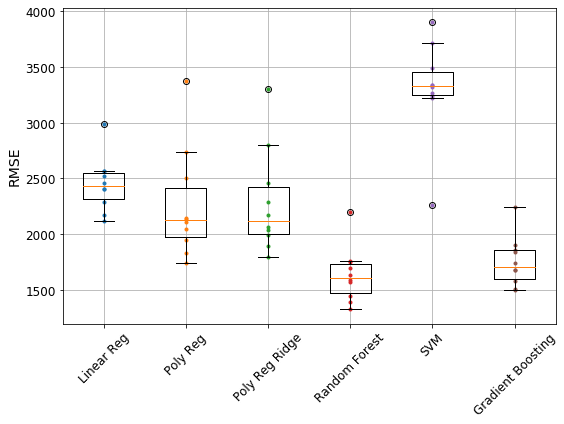

In [722]:
plt.figure(figsize=(8, 6))
plt.plot([1]*10, lin_reg_scores, ".")
plt.plot([2]*10, poly_reg_scores, ".")
plt.plot([3]*10, ridge_poly_reg_scores, ".")
plt.plot([4]*10, forest_reg_scores, ".")
plt.plot([5]*10, svm_reg_scores, ".")
plt.plot([6]*10, gb_reg_scores, ".")
plt.boxplot([lin_reg_scores, poly_reg_scores, ridge_poly_reg_scores,
             forest_reg_scores, svm_reg_scores, gb_reg_scores],
            labels=("Linear Reg","Poly Reg", "Poly Reg Ridge", "Random Forest",
                                                 "SVM", "Gradient Boosting"))
plt.xticks(rotation=45)
plt.ylabel("RMSE", fontsize=14)
plt.grid(True)
save_fig("box_plot_scores")
plt.show()

We see that Polynomial Regression did slightly better than plain Linear Regression. Also, Random Forest Regressor and Gradient Boosting Regressor performed significantly better while SVM Regressor performed significantly worse. Remember we are just trying to get a general idea of which Machine Learning algorithms perform the best so all of these algorithms were trained with default settings.

# Fine-tune the System

Now we have a shortlist of promising models. We now need to fine-tune them. Since we trained our models using default hyperparameters we will try and see which hyperparameters work best for our best models, Random Forest Regressor and Gradient Boosting Regressor.

Instead of doing this manually, we get Scikit-Learn’s GridSearchCV to search for us. All we need to do is tell it which hyperparameters we want it to experiment with and what values to try out, and it will use cross-validation to evaluate all possible combinations of hyperparameter values.

## Random Forest

In [700]:
from sklearn.model_selection import GridSearchCV

forest_param_grid = [{'bootstrap': [True],
     'max_depth': [12, 14, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2],
     'min_samples_split': [ 2, 3],
     'n_estimators': [100, 200, 300, 400]}
    ]

forest_reg = RandomForestRegressor()

forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, cv=5,
                                  scoring="neg_mean_squared_error",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

forest_grid_search.fit(cars_prepared, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.2min finished
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'max_depth'

We can get the best estimator directly:

In [701]:
forest_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [702]:
def grid_search_top_scores(cvres, k):
    results = []
    for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
        results.append((np.sqrt(-mean_score), params))
    results.sort(key=lambda x:x[0])
    for item in results[:k]:
        print(item)

In [703]:
cvres = forest_grid_search.cv_results_

grid_search_top_scores(cvres, 5)

(1678.3232263896753, {'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 400})
(1680.279835972783, {'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200})
(1680.6881497796226, {'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300})
(1680.9853928021605, {'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300})
(1683.4905310921906, {'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100})


## Gradient Boosting

In [715]:
gb_param_grid = [{'loss': ['ls'],
         'learning_rate': [0.05, 0.1, 0.15],
         'n_estimators': [200, 220, 240, 260],
         'subsample': [0.8, 0.9],
         'min_samples_split': [2, 3],
         'min_samples_leaf': [2, 3, 4],
         'max_depth': [4, 5, 6, 7],
         'max_features': ['sqrt'],
        }]

gb_reg = GradientBoostingRegressor()

gb_grid_search = GridSearchCV(gb_reg, gb_param_grid, cv=5,
                                  scoring="neg_mean_squared_error",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

gb_grid_search.fit(cars_prepared, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  2.5min finished
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [716]:
gb_grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [717]:
cvres = gb_grid_search.cv_results_

grid_search_top_scores(cvres, 5)

(1662.9664520824047, {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 0.9})
(1662.979587035745, {'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 220, 'subsample': 0.9})
(1664.0236462302769, {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 0.8})
(1665.081655531237, {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 220, 'subsample': 0.8})
(1666.1270851513218, {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 0.9})


## Ensemble: Random Forest & Gradient Boosting

Another way to fine-tune your system is to try and combine the models that perform best. The group (or “ensemble”) will often perform better than the best individual model. Now that we tuned our hyperparameters of our best two models let’s try and combine them to improve our best score even more.

This is relatively easy to do with Scikit-Learn’s VotingRegressor() class which allows us to take the average prediction of our Random Forest Regressor and Gradient Boosting Regressor.

In [718]:
from sklearn.ensemble import VotingRegressor

forest_reg = RandomForestRegressor(**forest_grid_search.best_params_)
gb_reg = GradientBoostingRegressor(**gb_grid_search.best_params_)

forest_gb_reg = VotingRegressor([("forest_reg", forest_reg), ("gb_reg", gb_reg)])

forest_gb_reg_scores = np.sqrt(-cross_val_score(forest_gb_reg, cars_prepared, y_train, cv=10,
                                         scoring="neg_mean_squared_error"))

In [719]:
display_scores(forest_gb_reg_scores)

Scores: [1383.17596721 1758.03775971 2183.87871632 1698.43792576 1395.56685939
 1708.16611464 1479.2306284  1642.28144505 1397.89487006 1339.17569663]
Mean: 1598.584598316986
Standard deviation: 245.21715304935594


Look at that it worked! Our mean RMSE is under 1600! Now that we have our best model it is time to analyze its errors. But first let’s make one last box plot comparing the four best models.

Saving figure best_models_box_plot_scores


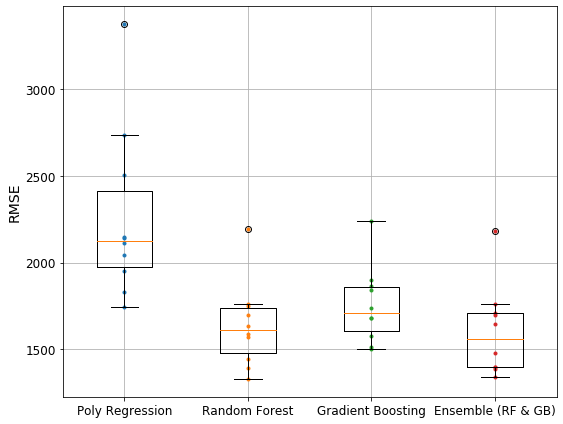

In [812]:
plt.figure(figsize=(8, 6))
plt.plot([1]*10, poly_reg_scores, ".")
plt.plot([2]*10, forest_reg_scores, ".")
plt.plot([3]*10, gb_reg_scores, ".")
plt.plot([4]*10, forest_gb_reg_scores, ".")
plt.boxplot([poly_reg_scores, forest_reg_scores, gb_reg_scores, forest_gb_reg_scores],
            labels=("Poly Regression", "Random Forest", "Gradient Boosting", "Ensemble (RF & GB)"))
plt.ylabel("RMSE", fontsize=14)
plt.grid(True)
save_fig("best_models_box_plot_scores")
plt.show()

Let’s save the best models so that we can come back easily to any of them!

In [728]:
import joblib

forest_gb_reg.fit(cars_prepared, y_train)

MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models/")
os.makedirs(MODELS_PATH, exist_ok=True)

for model, name in zip([gb_grid_search.best_estimator_, forest_grid_search.best_estimator_, forest_gb_reg],
                       ["gradient_boosting_reg", "forest_reg", "ensemble_(RF_&_GB)"]):
    joblib.dump(model, MODELS_PATH + name)

# Analyze best model and errors

We will use cross_val_predict to get a clean prediction on every instance in our training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Let’s plot our predicted price against the actual price. If all of our points were on the diagonal line that would mean our model is perfect and has an error of 0.

In [730]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(forest_gb_reg, cars_prepared, y_train, cv=10)

Saving figure actual_vs_predicted_price


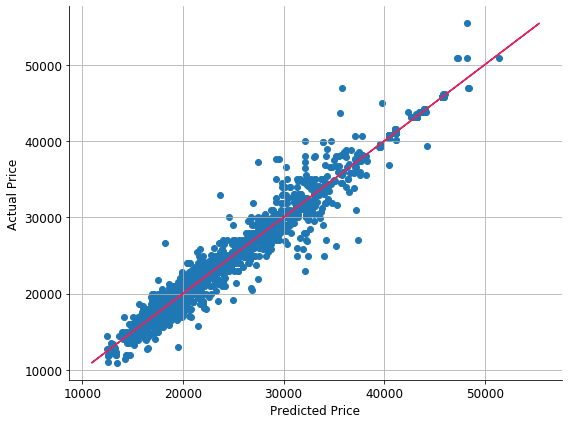

In [734]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(preds, y_train)
ax.plot(y_train, y_train, color='#dd2762')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Predicted Price', fontsize=12)
plt.ylabel('Actual Price', fontsize=12)
plt.grid()
save_fig("actual_vs_predicted_price");

This looks pretty good our errors are normally distributed opposed to missing low for one region and high for another. All that’s left is to evaluate on the test set and get one final performance check. Thankfully the test set is easy to prepare using the pipeline we created earlier!

# Evaluate system on the test set

In [770]:
test_set.drop(1032, axis=0, inplace=True)
X_test = test_set.drop("Price", axis=1)
y_test = test_set["Price"].copy()
X_test = X_test[cols]
X_test_prepared = full_pipeline.fit_transform(X_test)

In [771]:
from sklearn.metrics import mean_squared_error

final_predictions = forest_gb_reg.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

2207.826617808032

In [772]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([1897.65806784, 2479.49402221])

It seems we might’ve overfitted our training set a bit. It might be tempting to go back and try to perform better on the test set but then we risk overfitting the test set. We will leave it be as it is still in the range of scores we got on our training set.

# Conclusions

Now back to the original problem. Should you buy or lease your next car?
Now that we have our final model and performance score on the test set we can use it to predict the prices of Acura TLXs with features corresponding to various leases. The leases we use for comparison are from Acura’s website. Let’s look at multiple different lease terms and see what we find out!
The cars we predict have the following features and leases:

<img src="images/leases_of_cars_table.png" width="1000" height="1000">

For each of the cars listed above we will predict depreciation each year up to the term of the lease.  

In [817]:
acura_tlxs = {"Price": [40100, 40100, 40100,
                        36700, 36700, 
                        44800, 44800, 44800, 44800],
             "Year": [2019, 2018, 2017,
                      2019, 2018, 
                      2019, 2018, 2017, 2016],
             "Mileage": [12000, 24000, 36000,
                         10000, 20000, 
                         12000, 24000, 36000, 48000],
             "Accidents": [0, 0, 0,
                           0, 0,
                           0, 0, 0, 0],
             "Drive": ["FWD", "FWD", "FWD",
                       "FWD", "FWD", 
                       "SH-AWD", "SH-AWD", "SH-AWD", "SH-AWD"], 
             "Engine": ["3.5L V-6", "3.5L V-6", "3.5L V-6",
                        "2.4L Inline-4", "2.4L Inline-4",
                        "3.5L V-6", "3.5L V-6", "3.5L V-6", "3.5L V-6"],
             "Trim": ["3.5L FWD with Technology Package", "3.5L FWD with Technology Package", "3.5L FWD with Technology Package",
                      "2.4L FWD with Technology Package", "2.4L FWD with Technology Package",
                      "3.5L SH-AWD with A-Spec Package Red Leather", "3.5L SH-AWD with A-Spec Package Red Leather", "3.5L SH-AWD with A-Spec Package Red Leather", "3.5L SH-AWD with A-Spec Package Red Leather"
        ]}
acura_tlxs = pd.DataFrame(acura_tlxs)
acura_tlxs

,Price,Year,Mileage,Accidents,Drive,Engine,Trim
0,40100,2019,12000,0,FWD,3.5L V-6,3.5L FWD with Technology Package
1,40100,2018,24000,0,FWD,3.5L V-6,3.5L FWD with Technology Package
2,40100,2017,36000,0,FWD,3.5L V-6,3.5L FWD with Technology Package
3,36700,2019,10000,0,FWD,2.4L Inline-4,2.4L FWD with Technology Package
4,36700,2018,20000,0,FWD,2.4L Inline-4,2.4L FWD with Technology Package
5,44800,2019,12000,0,SH-AWD,3.5L V-6,3.5L SH-AWD with A-Spec Package Red Leather
6,44800,2018,24000,0,SH-AWD,3.5L V-6,3.5L SH-AWD with A-Spec Package Red Leather
7,44800,2017,36000,0,SH-AWD,3.5L V-6,3.5L SH-AWD with A-Spec Package Red Leather
8,44800,2016,48000,0,SH-AWD,3.5L V-6,3.5L SH-AWD with A-Spec Package Red Leather


We concat with the original training data first to ensure every OneHotEncoded categorical variable exists as a column.  

In [818]:
X_acura_tlxs = acura_tlxs.drop("Price", axis=1)

acura_tlxs = pd.concat([X_train, acura_tlxs], axis=0)
acura_tlxs_prepared = full_pipeline.fit_transform(acura_tlxs)[-9:, :]

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [819]:
acura_tlxs_prepared.shape

(9, 32)

In [879]:
acura_tlxs_preds = forest_gb_reg.predict(acura_tlxs_prepared)

lease_1_preds = np.insert(acura_tlxs_preds[:3], 0, 40100, axis=0)
lease_1_dep = 40100 - lease_1_preds
lease_1_cost = np.array([0, 9312, 18624, 27936])
lease_1_values = 40100 - np.array([0, 9312, 18624, 27936])

lease_2_dep = 36700 - lease_2_preds
lease_2_preds = np.insert(acura_tlxs_preds[3:5], 0, 36700, axis=0)
lease_2_cost = np.array([0, 11412, 22824])
lease_2_values = 36700 - np.array([0, 11412, 22824])

lease_3_dep = 44800 - lease_3_preds
lease_3_preds = np.insert(acura_tlxs_preds[5:], 0, 44800, axis=0)
lease_3_cost = np.array([0, 9024, 18048, 27072, 36096])
lease_3_values = 44800 - np.array([0, 9024, 18048, 27072, 36096])

In [880]:
lease_1_cost

array([    0,  9312, 18624, 27936])

Saving figure predictions_vs_cost_of_lease


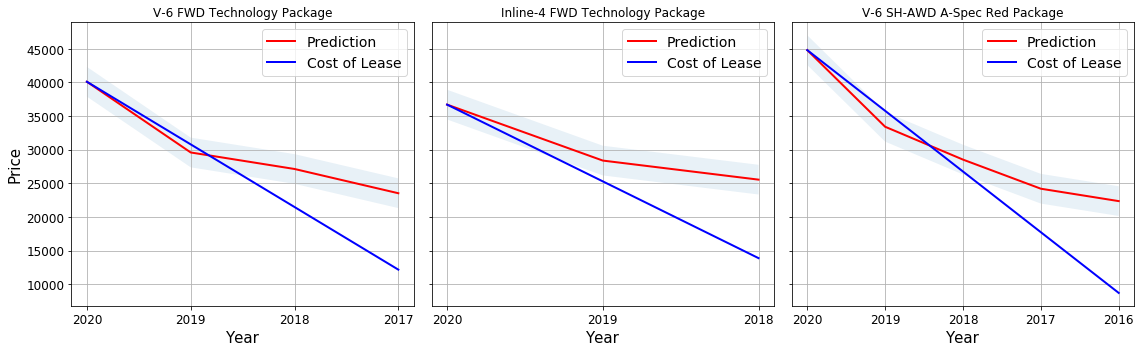

In [892]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(16, 5))

ax = axes[0]
ax.grid(True)
ax.plot([0, 1, 2, 3], lease_1_preds, "r-", linewidth=2, label="Prediction")
ax.plot([0, 1, 2, 3], lease_1_values, "b-", linewidth=2, label="Cost of Lease")
ax.fill_between([0, 1, 2, 3], (lease_1_preds - final_rmse), (lease_1_preds + final_rmse), alpha=0.1)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["2020", "2019", "2018", "2017"])
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Price", rotation=90, fontsize=15)
ax.set_title("V-6 FWD Technology Package")
ax.legend(loc="upper right", fontsize=14)

ax = axes[1]
ax.grid(True)
ax.plot([0, 1, 2], lease_2_preds, "r-", linewidth=2, label="Prediction")
ax.plot([0, 1, 2], lease_2_values, "b-", linewidth=2, label="Cost of Lease")
ax.fill_between([0, 1, 2], (lease_2_preds - final_rmse), (lease_2_preds + final_rmse), alpha=0.1)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["2020", "2019", "2018"])
ax.set_xlabel("Year", fontsize=15)
ax.set_title("Inline-4 FWD Technology Package")
ax.legend(loc="upper right", fontsize=14)

ax = axes[2]
ax.grid(True)
ax.plot([0, 1, 2, 3, 4], lease_3_preds, "r-", linewidth=2, label="Prediction")
ax.plot([0, 1, 2, 3, 4], lease_3_values, "b-", linewidth=2, label="Cost of Lease")
ax.fill_between([0, 1, 2, 3, 4], (lease_3_preds - final_rmse), (lease_3_preds + final_rmse), alpha=0.1)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(["2020", "2019", "2018", "2017", "2016"])
ax.set_xlabel("Year", fontsize=15)
ax.set_title("V-6 SH-AWD A-Spec Red Package")
ax.legend(loc="upper right", fontsize=14)
save_fig("predictions_vs_cost_of_lease");

Saving figure depreciation_vs_cost_of_lease


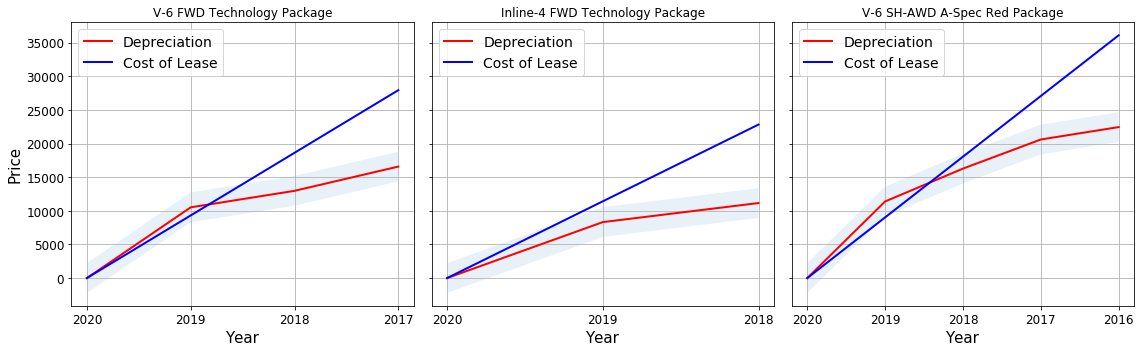

In [893]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(16, 5))

ax = axes[0]
ax.grid(True)
ax.plot([0, 1, 2, 3], lease_1_dep, "r-", linewidth=2, label="Depreciation")
ax.plot([0, 1, 2, 3], lease_1_cost, "b-", linewidth=2, label="Cost of Lease")
ax.fill_between([0, 1, 2, 3], (lease_1_dep - final_rmse), (lease_1_dep + final_rmse), alpha=0.1)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["2020", "2019", "2018", "2017"])
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Price", rotation=90, fontsize=15)
ax.set_title("V-6 FWD Technology Package")
ax.legend(loc="upper left", fontsize=14)

ax = axes[1]
ax.grid(True)
ax.plot([0, 1, 2], lease_2_dep, "r-", linewidth=2, label="Depreciation")
ax.plot([0, 1, 2], lease_2_cost, "b-", linewidth=2, label="Cost of Lease")
ax.fill_between([0, 1, 2], (lease_2_dep - final_rmse), (lease_2_dep + final_rmse), alpha=0.1)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["2020", "2019", "2018"])
ax.set_xlabel("Year", fontsize=15)
ax.set_title("Inline-4 FWD Technology Package")
ax.legend(loc="upper left", fontsize=14)

ax = axes[2]
ax.grid(True)
ax.plot([0, 1, 2, 3, 4], lease_3_dep, "r-", linewidth=2, label="Depreciation")
ax.plot([0, 1, 2, 3, 4], lease_3_cost, "b-", linewidth=2, label="Cost of Lease")
ax.fill_between([0, 1, 2, 3, 4], (lease_3_dep - final_rmse), (lease_3_dep + final_rmse), alpha=0.1)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(["2020", "2019", "2018", "2017", "2016"])
ax.set_xlabel("Year", fontsize=15)
ax.set_title("V-6 SH-AWD A-Spec Red Package")
ax.legend(loc="upper left", fontsize=14)
save_fig("depreciation_vs_cost_of_lease");

And here are the predicted depreciation costs and leases compared for the three different trims. The red line represents the predicted depreciation cost while the blue line represents the cost of the lease. The shaded area represents the 95% confidence intervals around our predicted depreciation. We see that in all three cases the lease is a lot more expensive.

You can save up to $10,000 if you choose to buy the car new. Leasing happens to be a lot more expensive even for one of the best rated cars.  

## Future work

After concluding the project, some ideas had popped in my head that I thought would be interesting:
* We can model different cars who also have high rated leases and see by how much can you finance a new car that it will still be worth buying and reselling.
* Ensembling seemed beneficial here from cross-validation but still performed poorly on the test set. Exploring why could be interesting. I wonder if all the other models would perform worse on the test set or our final model in fact wasn’t the best choice despite performing best on all folds of cross validation.
* Take this problem further and try to model multiple car makes and models that can still predict accurately the value of the car.

As always thank you for reading I hope you enjoyed it and learned something new and insightful!